# EXPLORATION 5. 나의 첫번째 캐글 경진대회, 무작정 따라해보기

### 학습 목표

1. 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
2. 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
3. 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드 Private score 기준 110000 이하의 점수를 얻었는가?

### 필요한 라이브러리 import 및 데이터 불러오기

In [1]:
# 시각화 그래프를 위한 matplotlib import

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# 필요한 라이브러리 import

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('goodluck')

goodluck


In [3]:
# 데이터 불러오기

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [4]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


  - 학습데이터는 15035개 / 테스트데이터는 6468개로 이루어져 있는 것을 볼 수 있다.
  - 테스트데이터는 price 칼럼이 없기 때문에 1개 적은 것을 볼 수 있다.

### 간단한 데이터 전처리 과정

In [5]:
# 학습데이터에서 price 칼럼 제거하기

y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
# 학습데이터와 테스트데이터 합치기
# 모델을 학습시키기 전에 전체 데이터에 대해 탐색하기 위해 두 데이터를 pd.concat으로 합쳐준다.

train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))
data.head()

21503


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


  - 학습데이터 15035개와 테스트데이터 6468개가 합쳐져서 21503개가 된 것을 확인할 수 있다.

In [7]:
# 필요없는 id 칼럼 제거하기

sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [8]:
# date 칼럼은 필요한 부분만 잘라내주기 - 데이터를 연/월 데이터만 사용하기 위해 6자리로 잘라줌

data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


  - date 칼럼이 연/월로 정리되고 뒷 자리는 잘려진 것을 확인할 수 있다.

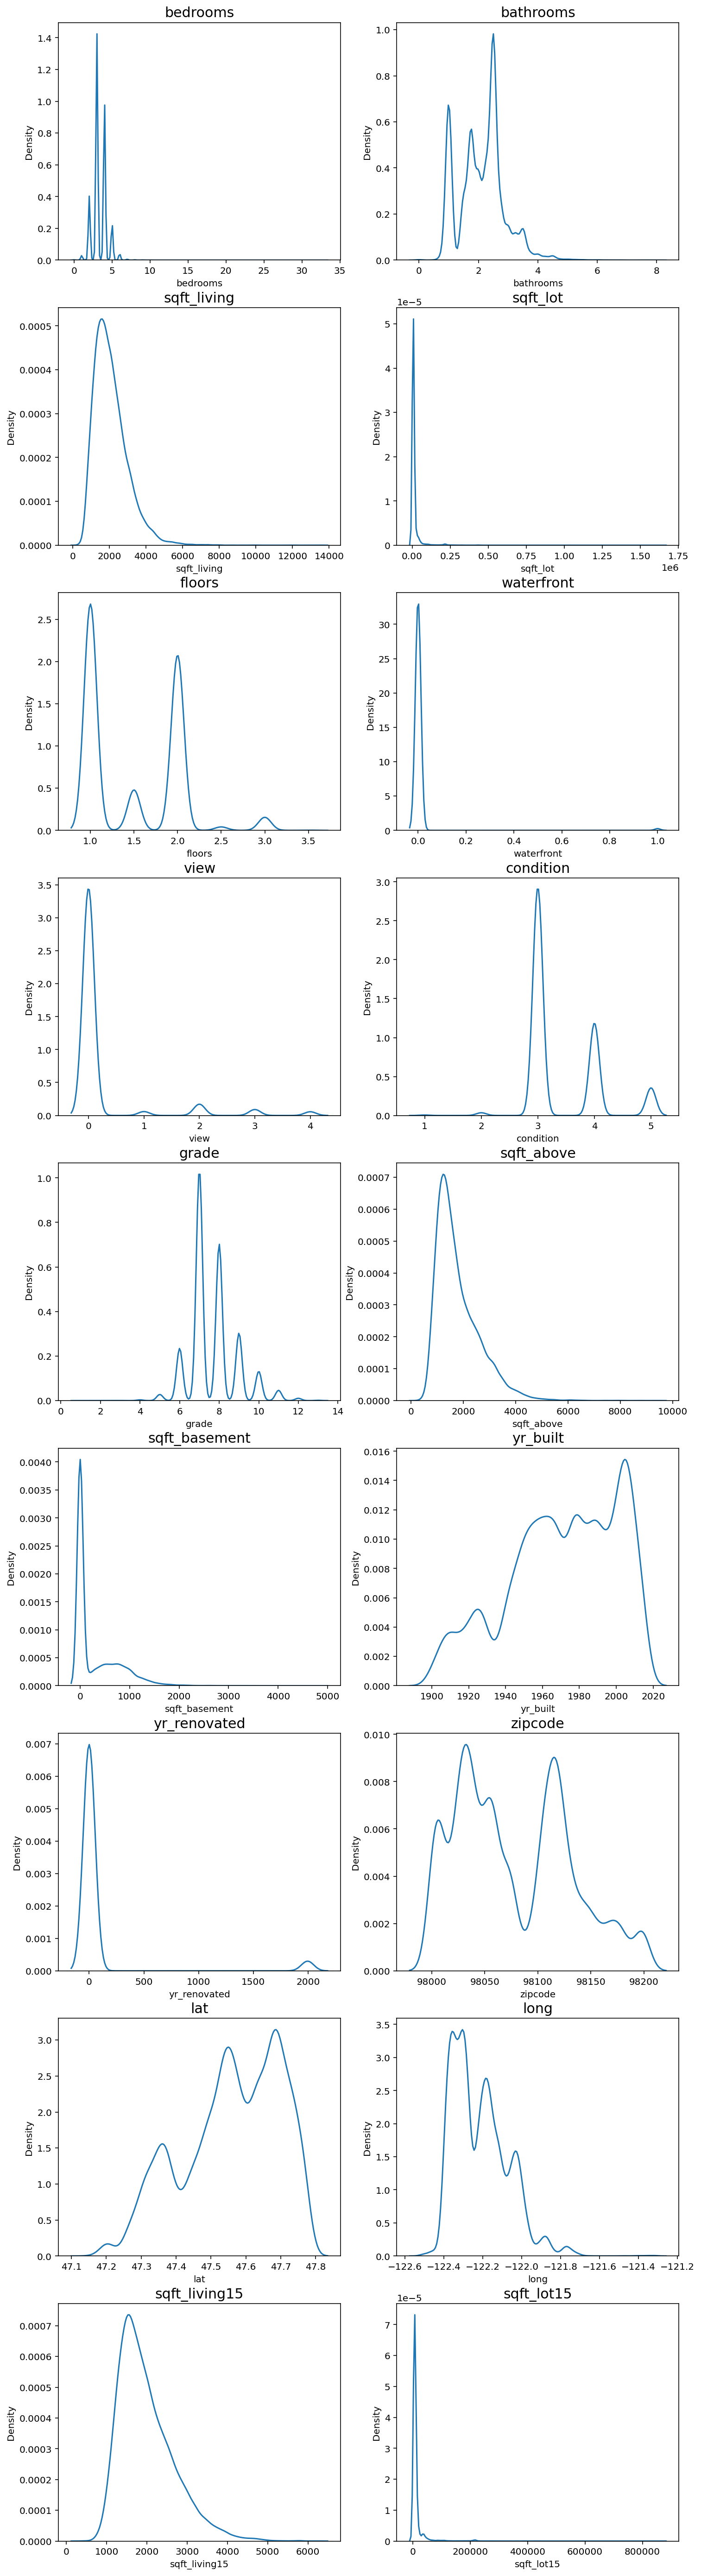

In [9]:
# 전체 데이터 탐색
# 이 과정을 통해서 너무 치우친 분포를 가지는 칼럼을 찾아 다듬어 주는 작업을 진행할 수 있다.
# 그래프는 sns.kdeplot를 사용한다. kdeplot은 부드러운 곡선으로 전체 분포를 확인할 수 있도록 도와준다.

fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

  - 위 그래프를 통해서 bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15 변수가 한쪽으로 치우친 경향을 보이는 것을 확인할 수 있다.
  - 이렇게 한쪽으로 치우친 분포의 경우에는 로그변환(log-scaling)을 통해서 데이터 분포를 정규분포에 가깝게 만들 수 있다.
  - 치우친 칼럼들을 skew_columns 리스트에 담고 모두 np.log1p( )를 사용해서 로그 변환을 해준다.

In [17]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

print('goodluck')

goodluck


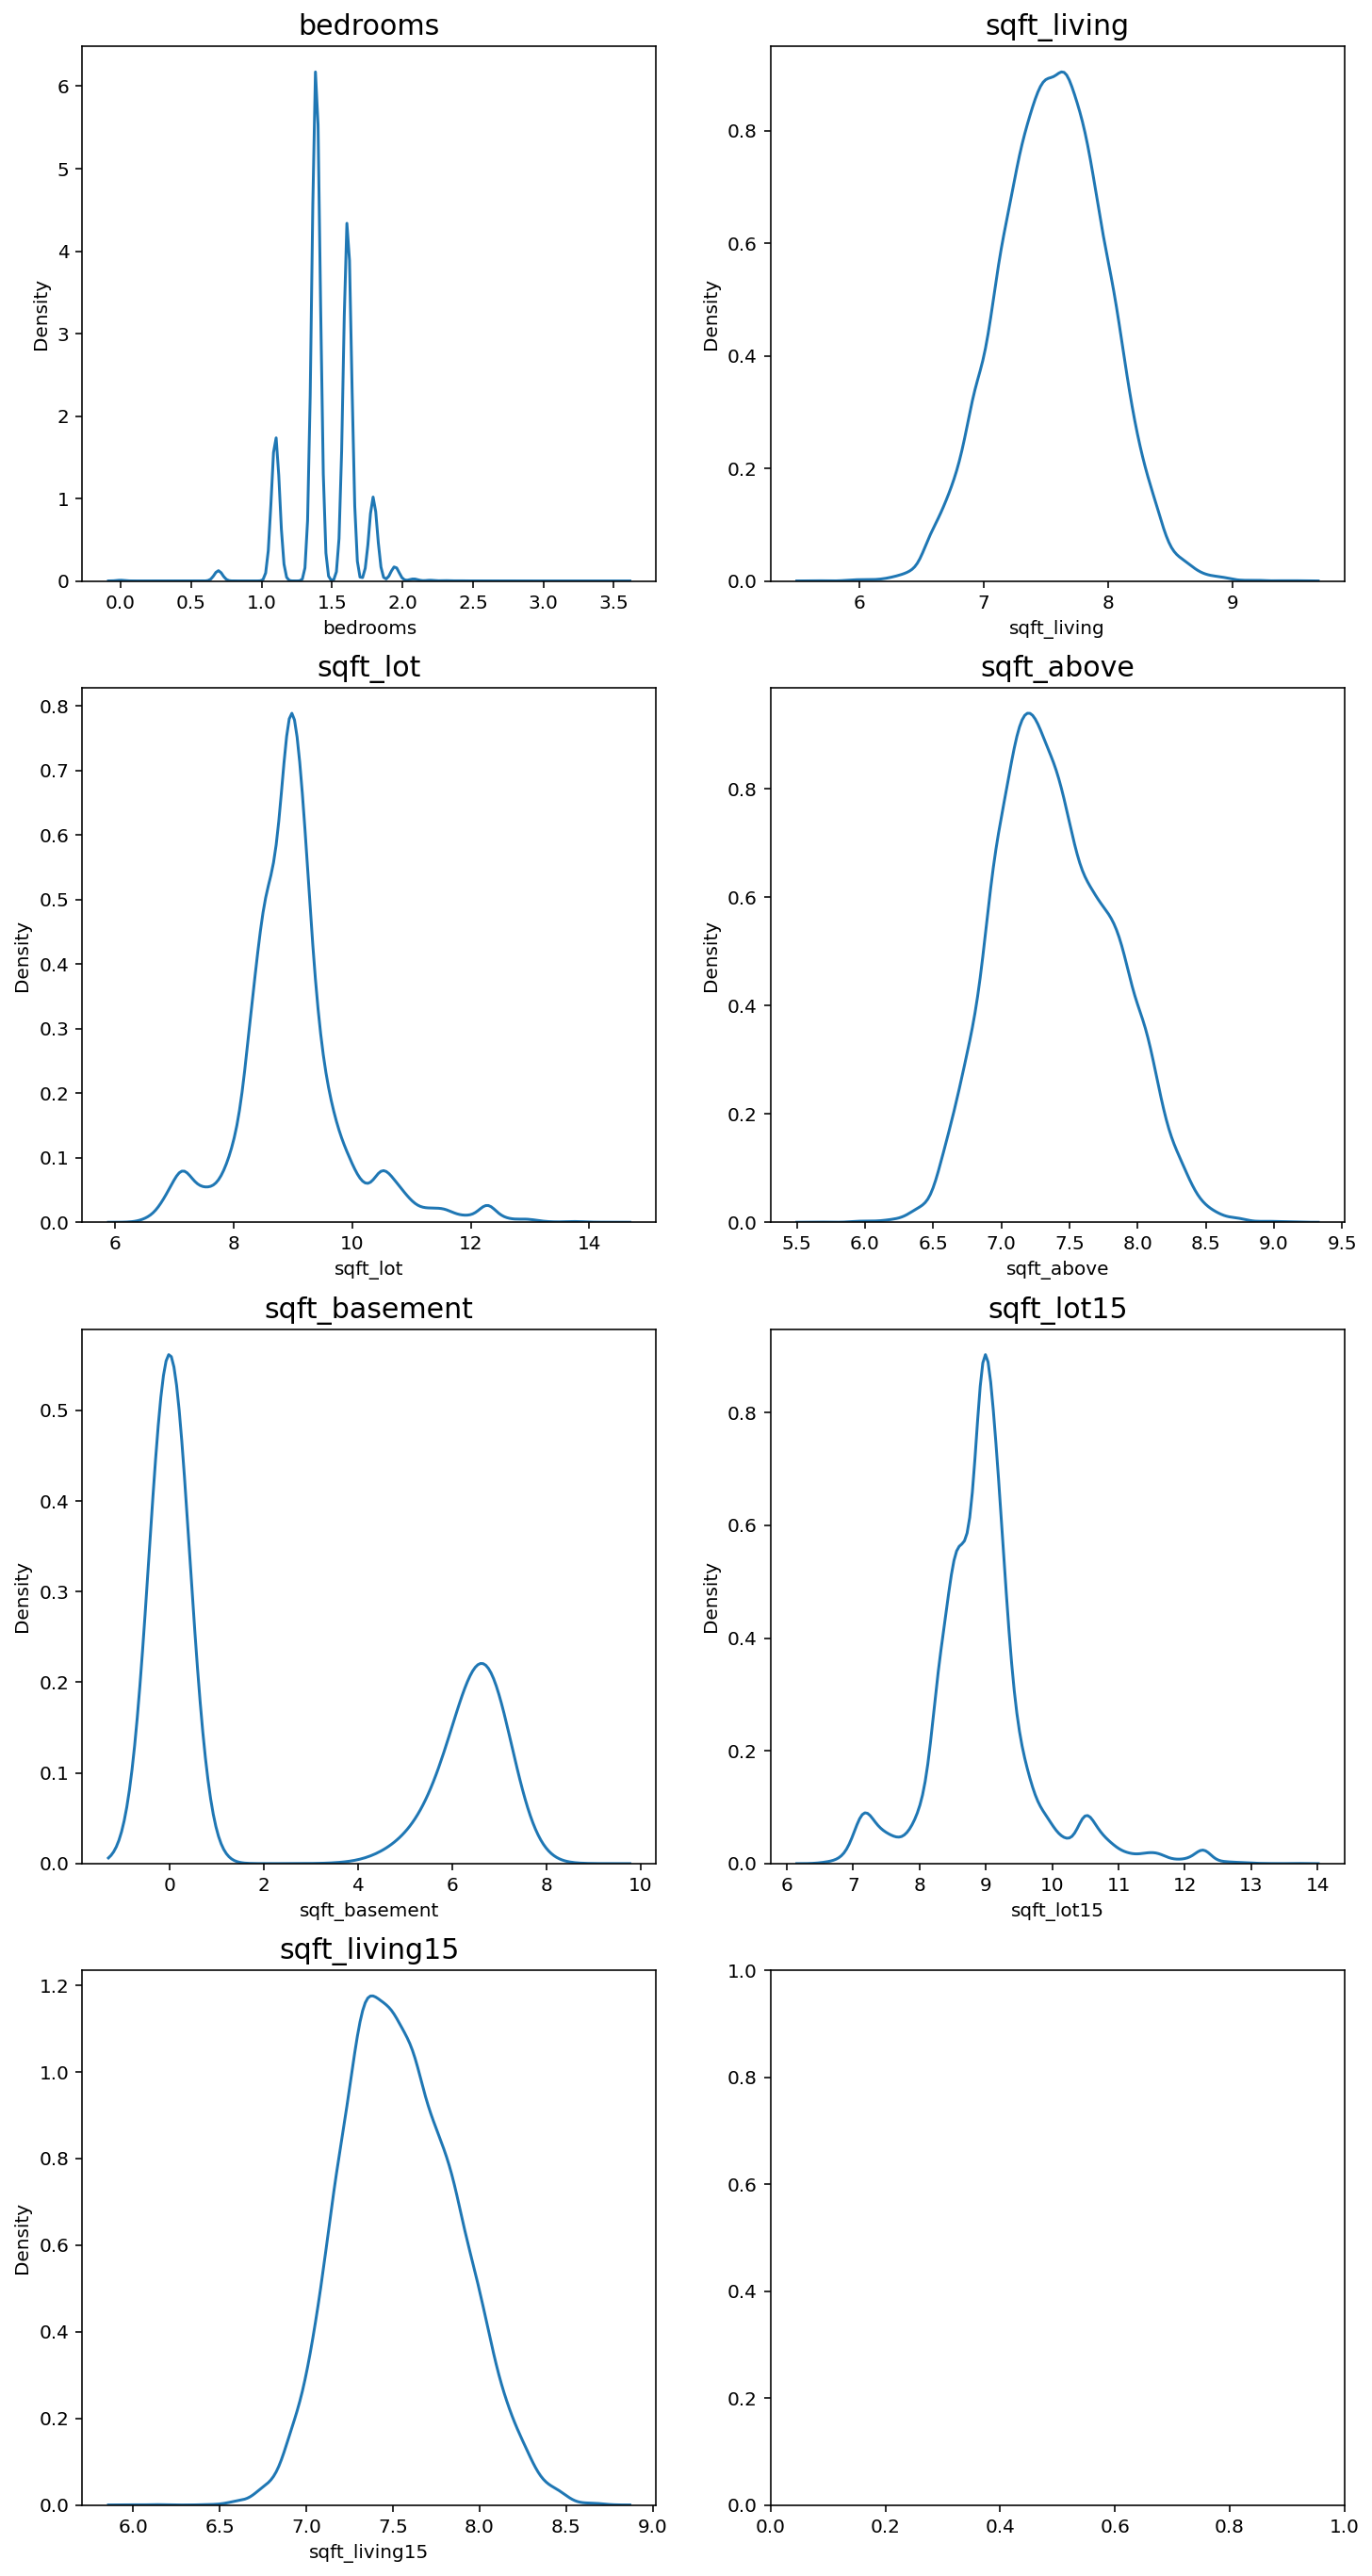

In [11]:
# 변환된 분포 확인

fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

In [18]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


### 모델 설계

  - 이번 모델에는 여러가지 모델을 함께 사용해서 결과를 섞는 블렌딩(blending)이라는 기법을 활용한다.
  - 블렌딩은 하나의 개별 모델을 사용하는 것이 아닌 다양한 모델을 종합해서 결과를 얻는 기법으로 앙상블 기법이라고도 한다.

In [19]:
# Average Blending
# 여러가지 모델의 결과를 산술평균하여 블렌딩 모델을 만든다.
# 모델은 부스팅 계열인 gboost, xgboost, lightgbm 세가지를 사용한다.

gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('goodluck')

goodluck


In [25]:
# Cross Validation
# 교차 검증을 통해 모델의 성능을 평가할 수 있다.

def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
print('goodluck')

goodluck


In [26]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


### Make Submission File

In [27]:
# 여러 모델을 입력하면 각 모델에 대한 예측 결과를 평균 내어 주는 AveragingBlending() 함수를 만들어 사용한다.
# AveragingBlending() 함수는 models 안에 있는 모델들을 모두 x와 y로 학습시킨 뒤 predictions에 결과값을 모아서 평균한 값을 반환한다.

def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('goodluck')

goodluck


In [28]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

  - 예측한 결과값을 캐글에 제출하기 위해서 샘플 파일을 확인하고 샘플 파일처럼 변환해서 csv 파일을 만들어준다.

In [18]:
# sample_submission.csv 파일 확인

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


  - id와 price 두 가지의 열로 구성되어 있는 것을 확인할 수 있다.

In [19]:
# 결과값을 가지고 우리도 id와 price로 구성된 데이터 프레임을 만들어준다.

result = pd.DataFrame({
    'id' : sub_id,
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [20]:
# submission.csv로 저장하기

my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


  - 케글에 올렸을 때 다음과 같은 점수를 받았다.
  - 목표 점수인 110000에 미치지 못하기 때문에 모델을 개선해서 다시 평가를 진행한다.

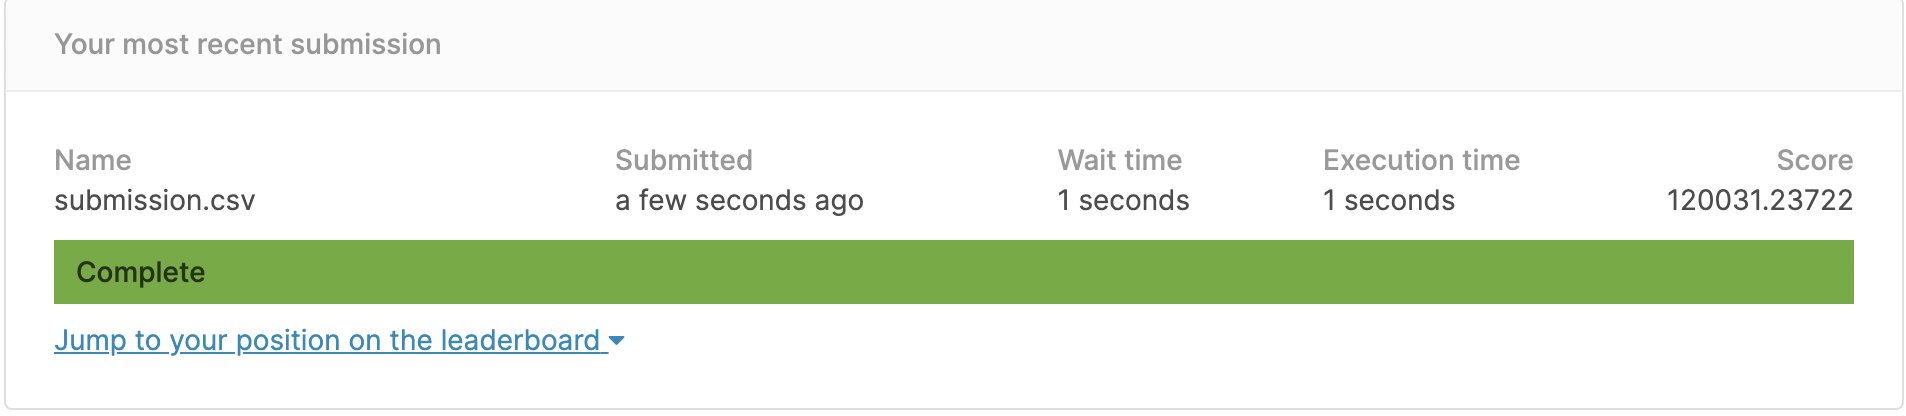

## 다시 내 입맛대로 데이터 준비하기

  - 목표점수인 110000점을 위해서 모델 개선 작업을 준비한다.
  - 모델을 따로 건드리지는 않고 모델에 들어가는 하이퍼파라미터를 조정해서 결과값을 내보려고 한다.

In [48]:
# 데이터 가져오기

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('hello')

hello


In [49]:
# 데이터 살펴보기

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [50]:
# 지금 date의 표시가 너무 길게 되어 있기 때문에 6자리까지만 출력되도록 해준다.

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [51]:
# price는 타겟데이터기 때문에 칼럼에서 지워준다.

y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [52]:
# id 칼럼 역시 사용하지 않기 때문에 지워준다.

del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [53]:
# test 데이터 역시 같은 작업을 진행해준다.
# test에는 price 칼럼이 없이 때문에 그 부분은 빼주고 작업을 진행한다.

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [56]:
# 타겟 데이터 y 확인
# 아까 제거한 Pirce 칼럼을 y에 저장해두었다.

y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

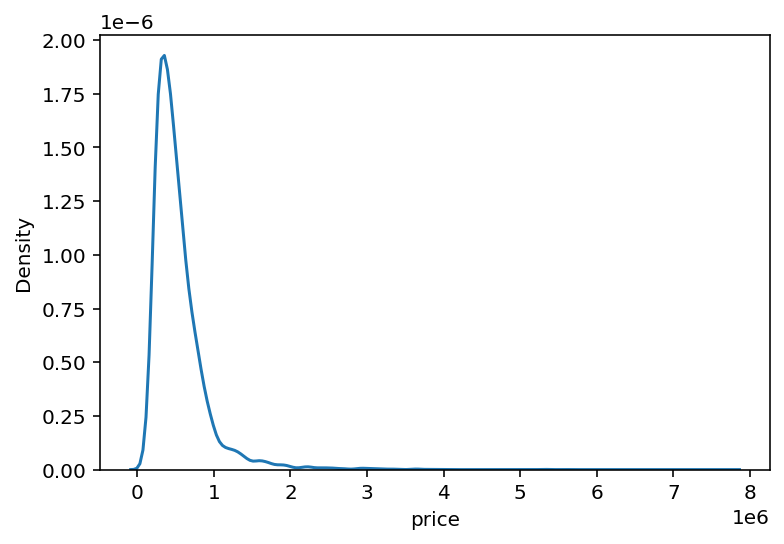

In [57]:
# 데이터 가격의 분포 확인

sns.kdeplot(y)

plt.show()

  - 여기서 price의 값이 왼쪽으로 크게 치우친 것을 확인할 수 있다.
  - 그렇기 때문에 y의 값을 np.log1p( ) 로 변환해주고 나중에 모델이 값을 예측한 후 np.expm1( )로 되돌려준다.

In [58]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

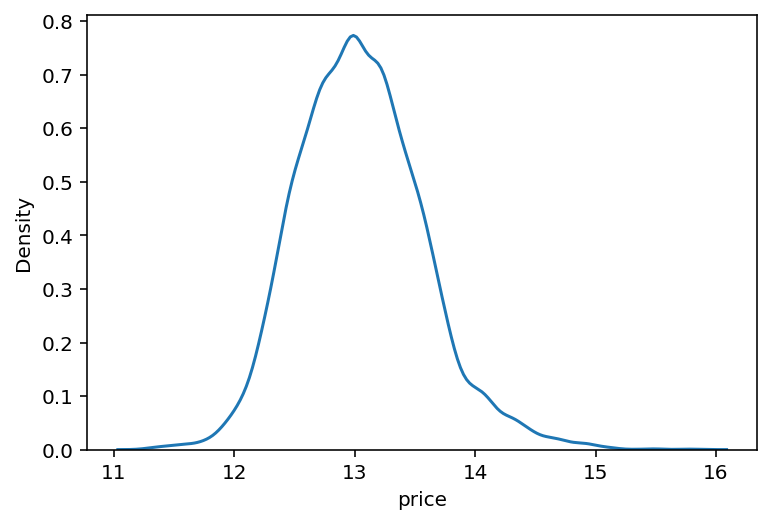

In [59]:
sns.kdeplot(y)

plt.show()

In [60]:
# 함수 전체 데이터 확인

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

  - 모두 실수 또는 정수 자료형으로 설정되서 문제 없이 사용할 수 있다.

### RMSE 계산
  - 대회의 평가 척도인 RMSE를 계산하기 위해서 함수를 만들어준다.
  - 여기서 주의할 점은 먼저 y_test와 y_pred는 지금 np.log1p로 변환되어 있기 때문에 원래 데이터 단위에 맞게 np.expm1을 사용해서 변환해줘야 한다.
  - exp로 변환해서 mean_squared_error을 계산한 후 np.sqrt를 취하면 RMSE값을 구할 수 있다.

In [61]:
# 사용할 라이브러리 불러오기

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('hello')

hello


In [62]:
# RMSE 함수 만들기

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('hello')

hello


In [63]:
# 사용할 모델 불러오기 - XGBRegressor / LGBMRegressor / GradientBoostingRegressor / RandomForestRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('hello')

hello


In [64]:
# 모델 인스턴스 생성한 후 Models 리스트에 넣어주기

random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('hello')

hello


In [65]:
# 각 모델의 이름은 클래스의 __name__ 속성에 접근해서 얻을 수 있다.

xgboost.__class__.__name__

'XGBRegressor'

In [66]:
# for문을 통해서 각 모델별로 RMSE 값을 얻을 수 있다.

def get_scores(models, train, y):
        df = {}
    
        for model in models:
            model_name = model.__class__.__name__

            X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            df[model_name] = rmse(y_test, y_pred)
            score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

        return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


### 그리드 탐색
  - 그리드 탐색은 사람이 탐색할 하이퍼파라미터의 값을 정해두고 그 값들로 만들어질 수 있는 모든 조합을 탐색하는 것이다.
  - 특정 값에 대한 하이퍼파라미터 조합을 탐색하고자 할 때 유리하다.
  - 하지만 최적의 조합을 놓칠 수 있다는 단점이 있다.

In [42]:
from sklearn.model_selection import GridSearchCV
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

### LGBMRegressor 모델

In [30]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model_1 = LGBMRegressor(random_state=random_state)
my_GridSearch(model_1, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


  - 가장 좋은 파라미터 조합은 max_depth는 10 / n_estimators는 100으로 확인되었다.

In [43]:
# 최종 저장함수 만들기

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction # price 칼럼을 다시 추가해준다.
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle) # RMSE값도 넣어준다.
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [34]:
# 결과 예측 및 저장

model_1 = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
save_submission(model_1, train, y, test, 'LGBMRegressor', rmsle=None)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_LGBMRegressor_RMSLE_None.csv saved!


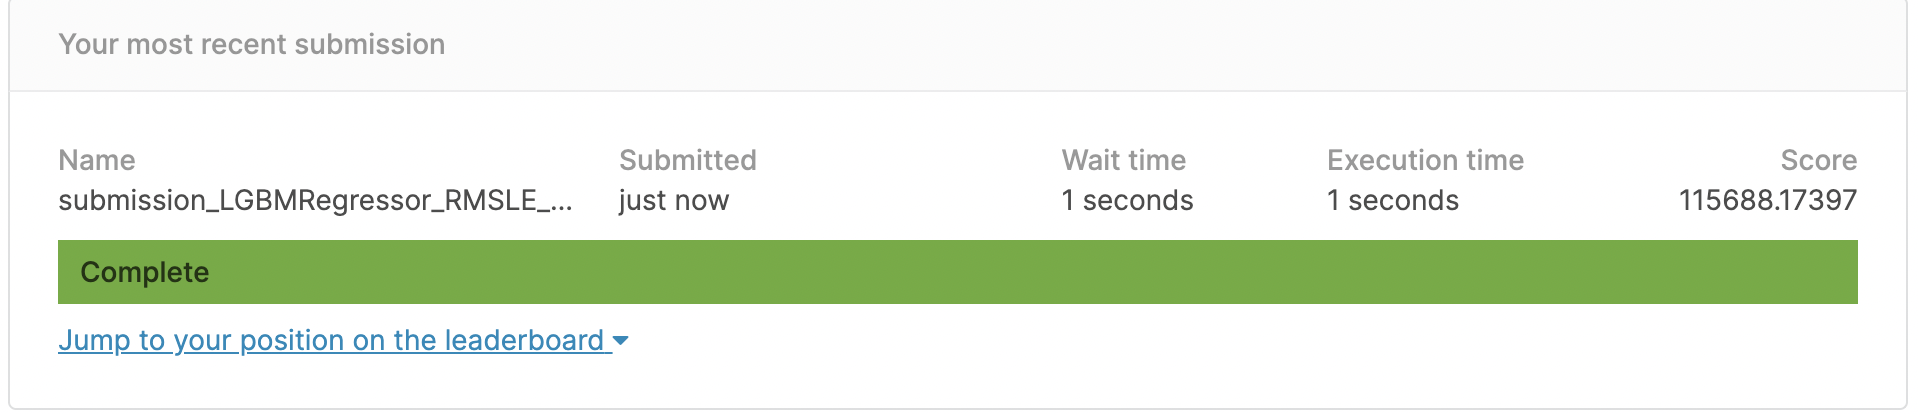

  - 노드를 따라서 진행한 결과값인 120000점보다는 떨어진 값을 얻었지만 아직 110000점 아래로 내려가지는 않았다.

### GradientBoostingRegressor 모델

In [25]:

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model_2 = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model_2, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.029483,0.171707
2,10,50,-0.029899,0.172913
1,1,100,-0.055036,0.234597
0,1,50,-0.073253,0.270653


[CV] END .......................max_depth=1, n_estimators=50; total time=   1.7s
[CV] END ......................max_depth=10, n_estimators=50; total time=   9.2s
[CV] END .....................max_depth=10, n_estimators=100; total time=  17.0s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.9s
[CV] END ......................max_depth=1, n_estimators=100; total time=   2.4s
[CV] END ......................max_depth=10, n_estimators=50; total time=   9.9s
[CV] END .....................max_depth=10, n_estimators=100; total time=  17.5s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.9s
[CV] END ......................max_depth=1, n_estimators=100; total time=   1.7s
[CV] END ......................max_depth=10, n_estimators=50; total time=  10.0s
[CV] END .....................max_depth=10, n_estimators=100; total time=  19.2s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.9s
[CV] END ...................

  - 최적의 파라미터 값은 max_depth는 10 / n_estimators는 100으로 확인되었다.

In [26]:
# 결과 예측 및 저장

model_2 = GradientBoostingRegressor(max_depth=10, n_estimators=100, random_state=random_state)
save_submission(model_2, train, y, test, 'GradientBoostingRegressor', rmsle=None)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_GradientBoostingRegressor_RMSLE_None.csv saved!


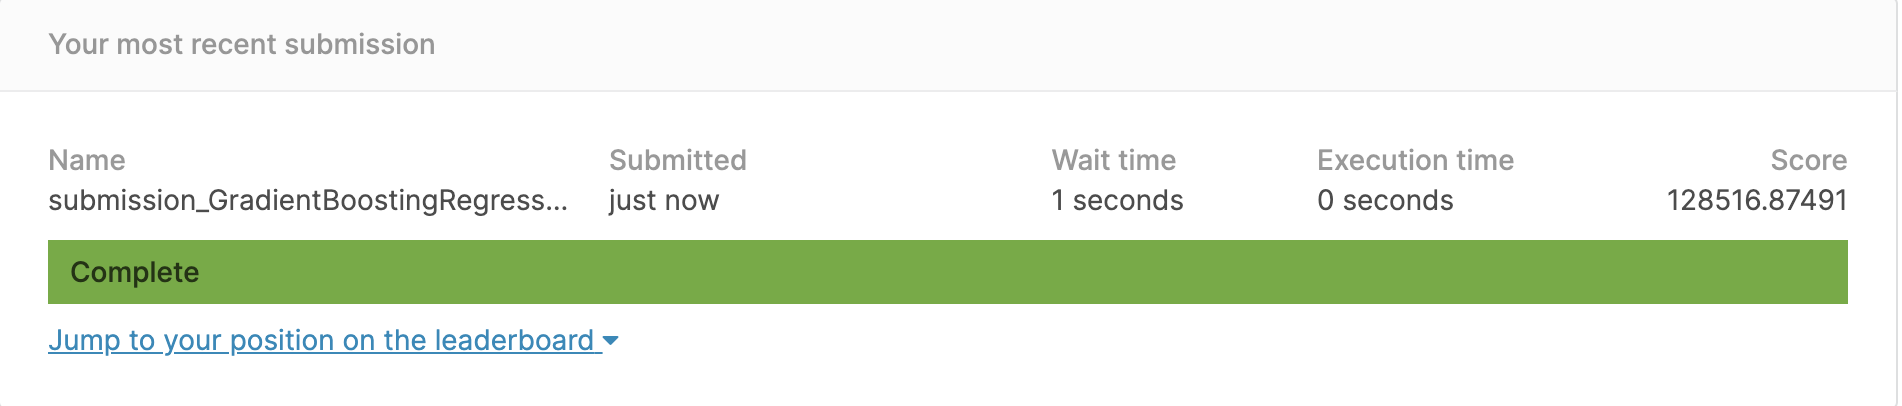

  - 이번엔 점수가 다시 120000을 넘어서서 확 증가한 것을 확인할 수 있었다.
  - 아무래도 몇가지 모델 클래스 인자를 더 추가해서 최적의 파라미터를 찾아봐야할 것 같다.

### XGBRegressor 모델

In [32]:

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [1, 10, 20],
    'learning_rate' : [0.001, 0.01, 0.1]
}

model_3 = XGBRegressor(random_state=random_state)
my_GridSearch(model_3, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warni

KeyboardInterrupt: 

  - XGBRegressor 모델로 파라미터를 찾으려고 하면 다음과 같은 오류가 나서 작동되지 않는다.
  - 그래서 위에서 진행했던 다른 모델들에게 모델 클래스 인자를 추가해서 진행하였다.

### LGBMRegressor 모델 (learning_rate 추가)

In [38]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, 40],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1]
}

model_4 = LGBMRegressor(random_state=random_state)
my_GridSearch(model_4, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
62,0.1000,40,300,-0.026091,0.161527
58,0.1000,30,300,-0.026091,0.161527
54,0.1000,20,300,-0.026091,0.161527
51,0.1000,10,400,-0.026121,0.161619
50,0.1000,10,300,-0.026127,0.161640
...,...,...,...,...,...
1,0.0001,10,200,-0.270132,0.519742
4,0.0001,20,100,-0.274318,0.523753
12,0.0001,40,100,-0.274318,0.523753
8,0.0001,30,100,-0.274318,0.523753


  - learning_rate 인자를 추가한 이후의 최적의 파라미터는 0.1 / 40 / 300 의 값이었다.

In [40]:
# 결과 예측 및 저장

model_4 = LGBMRegressor(learning_rate=0.1, max_depth=40, n_estimators=300, random_state=random_state)
save_submission(model_4, train, y, test, 'LGBMRegressor_2', rmsle=None)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_LGBMRegressor_2_RMSLE_None.csv saved!


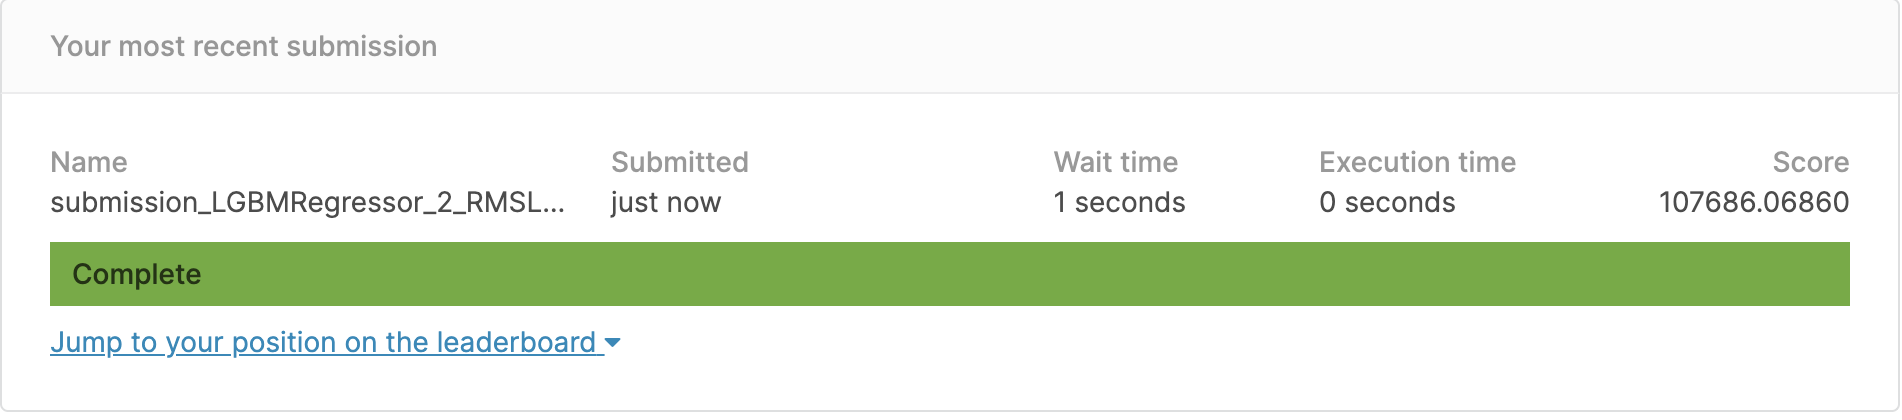

  - 모델 클래스 인자를 지정해주고서 얻은 결과는 110000점 아래 점수를 얻을 수 있었다.
  - 확실히 좀 더 세부적인 셋팅을 해주니까 더 좋은 결과를 얻는 것 같다.

### GradientBoostingRegressor 모델 (learning_rate 추가)

In [67]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'learning_rate' : [0.001, 0.01, 0.1]
}

model_5 = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model_5, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
19,0.100,10,200,-0.029427,0.171544
20,0.100,10,300,-0.029463,0.171647
18,0.100,10,100,-0.029483,0.171707
11,0.010,10,300,-0.031557,0.177642
10,0.010,10,200,-0.037185,0.192833
14,0.010,20,300,-0.051438,0.226800
21,0.100,20,100,-0.052130,0.228320
23,0.100,20,300,-0.052130,0.228320
22,0.100,20,200,-0.052130,0.228320
13,0.010,20,200,-0.052515,0.229161


[CV] END learning_rate=0.001, max_depth=10, n_estimators=100; total time=  25.7s
[CV] END learning_rate=0.001, max_depth=10, n_estimators=200; total time=  40.0s
[CV] END learning_rate=0.001, max_depth=10, n_estimators=300; total time= 1.1min
[CV] END learning_rate=0.001, max_depth=20, n_estimators=100; total time=  38.3s
[CV] END learning_rate=0.001, max_depth=20, n_estimators=200; total time= 1.1min
[CV] END learning_rate=0.001, max_depth=20, n_estimators=300; total time= 1.8min
[CV] END learning_rate=0.001, max_depth=30, n_estimators=100; total time=  37.8s
[CV] END learning_rate=0.001, max_depth=30, n_estimators=200; total time= 1.3min
[CV] END learning_rate=0.001, max_depth=30, n_estimators=300; total time= 1.8min
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=100; total time=  19.1s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=200; total time=  36.3s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=300; total time= 1.1min
[CV] END .learning_rate=0.01

[CV] END learning_rate=0.001, max_depth=10, n_estimators=100; total time=  20.8s
[CV] END learning_rate=0.001, max_depth=10, n_estimators=200; total time=  35.9s
[CV] END learning_rate=0.001, max_depth=10, n_estimators=300; total time=  59.7s
[CV] END learning_rate=0.001, max_depth=20, n_estimators=100; total time=  29.5s
[CV] END learning_rate=0.001, max_depth=20, n_estimators=200; total time= 1.3min
[CV] END learning_rate=0.001, max_depth=20, n_estimators=300; total time= 1.9min
[CV] END learning_rate=0.001, max_depth=30, n_estimators=100; total time=  44.2s
[CV] END learning_rate=0.001, max_depth=30, n_estimators=200; total time= 1.2min
[CV] END learning_rate=0.001, max_depth=30, n_estimators=300; total time= 1.9min
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=100; total time=  23.1s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=200; total time=  49.4s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=300; total time= 1.1min
[CV] END .learning_rate=0.01

In [69]:
# 결과 예측 및 저장

model_5 = GradientBoostingRegressor(learning_rate=0.1, max_depth=10, n_estimators=200, random_state=random_state)
save_submission(model_5, train, y, test, 'GradientBoostingRegressor_2', rmsle=None)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_GradientBoostingRegressor_2_RMSLE_None.csv saved!


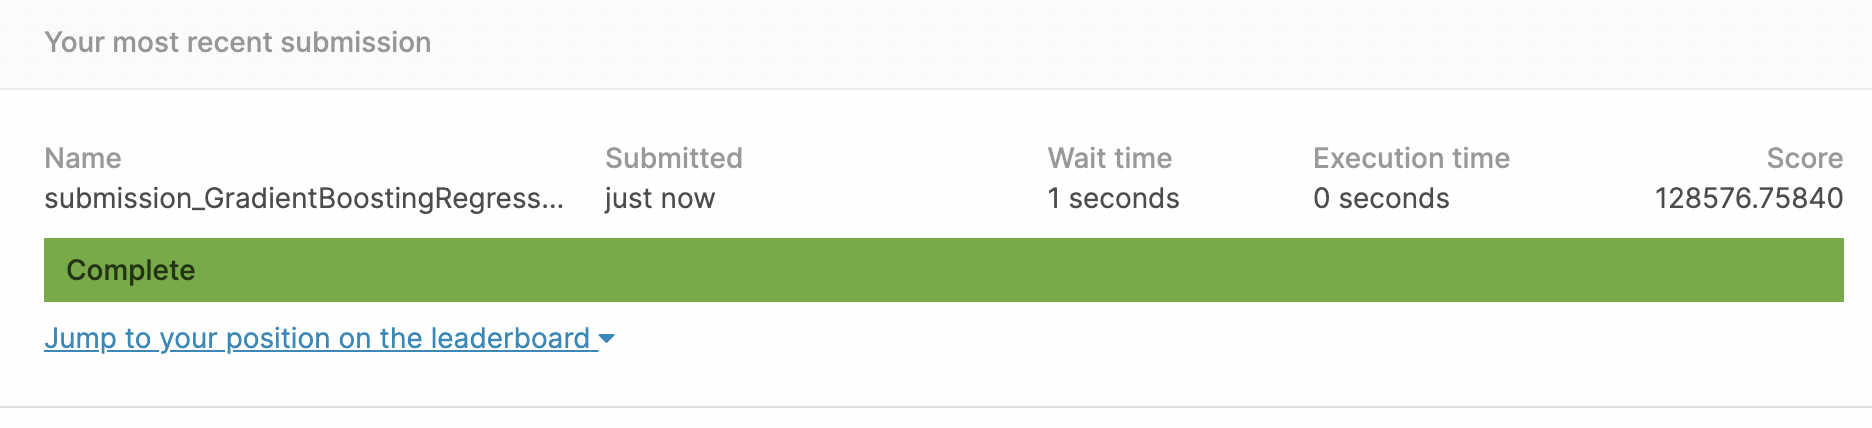

  - GradientBoostingRegressor 모델에 여러 인자를 변경해서 테스트한 점수는 120000 보다 더 올라갔다.

## 회고

  - 목표했던 110000 아래의 점수를 얻을 수 있었지만 특정 한 모델에서만 그 값을 얻을 수 있었고 나머지 모델들에서는 결과를 얻지 못하였다.
  - 모델 클라스 인자 변경을 통해서 목표 점수를 얻을 수 있었지만 그렇지 않은 모델들에 있어서는 어떤것들을 변경해주어야 좋은 결과를 얻을 수 있을지는 아직 답을 얻지 못하였다.
  - 특히 아쉬웠던 점은 XGBRegressor 모델에서는 오류가 떠서 테스트조차 하지 못했는데 구글에 검색을 해도 해당 오류가 어떤 내용인지 알 수 없었다. 혹시 아시면 알려주시면 감사할 것 같습니다.
  - 데이터 전처리 부분에 있어서도 잘 가공된 데이터가 좋은 결과를 가져오는 것 같아서 데이터 전처리에 대한 부분들을 좀 더 연습해서 능숙하게 해보도록 노력해야겠다는 생각이 들었다.